# Deep Learning Recommendation Model for Personalization and Recommendation Systems (DLRM)

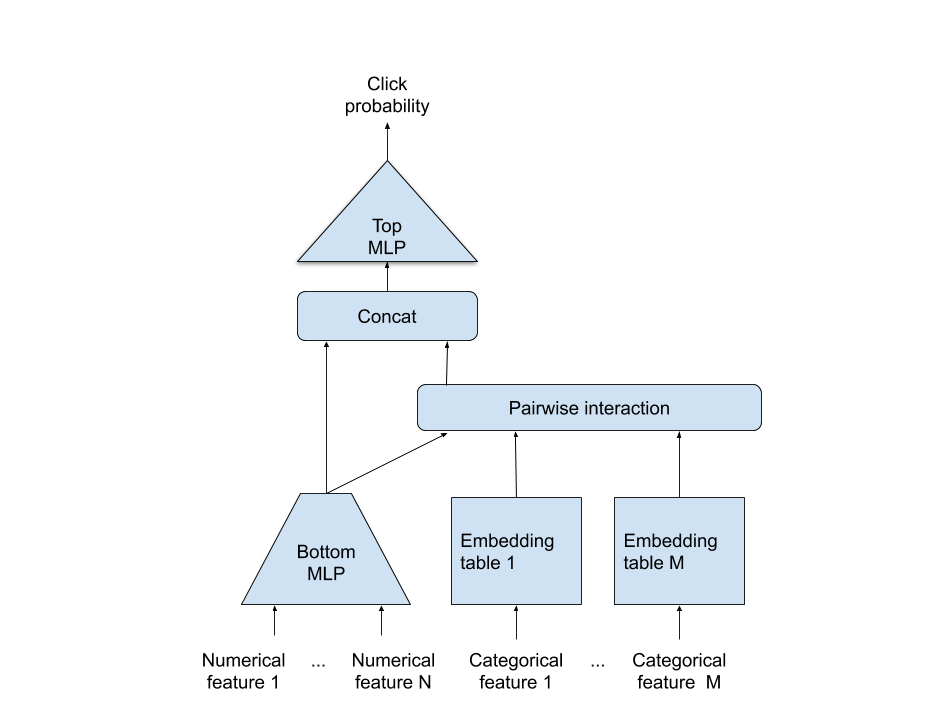

## Download the dataset

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as td

## Load and preprocess the data

In [2]:
import pandas as pd
from sklearn import preprocessing

In [3]:
import glob

In [4]:
DATA_DIR = "/Users/sergey.malyshev/projects/edu/2025-itmo-recsys/"

In [5]:
data = pd.concat([
    pd.read_json(data_path, lines=True) 
    for data_path 
    in glob.glob(DATA_DIR + "/data_10k/*/data.json")
])

In [7]:
tracks = pd.read_json("/Users/sergey.malyshev/projects/edu/2025-itmo-recsys/recsys-course-spring-2025/botify/data/tracks.json", lines=True)

In [10]:
tracks.head()

,artist,album,title,genre,pop,duration,track
0,Михаил Бублик,ART-Обстрел I-часть,Сорок тысяч верст,"[1, 47]",-0.500252,282,41164
1,Xamdam Sobirov,Baxtli Bo'lolmadik,Baxtli Bo'lolmadik,[1],-0.942953,205,27544
2,Сергей Какенов,Ишимская шпана,Крутые лагеря,[147],-0.801382,252,34702
3,Loc-Dog,Electrodog 2,Еду убивать,[17],-0.577525,276,45907
4,Gafur,Февраль,Февраль,[1],-0.738636,160,14978


In [11]:
data.head()

,message,timestamp,user,track,time,latency,recommendation,experiments
0,last,2025-03-18 10:49:48.692,5176,18839,0.00,0.000044,NaN,{'STICKY_ARTIST': 'T1'}
1,next,2025-03-18 10:49:48.694,6045,33432,1.00,0.000231,15024.0,{'STICKY_ARTIST': 'C'}
2,next,2025-03-18 10:49:48.695,6045,15024,0.67,0.000173,8389.0,{'STICKY_ARTIST': 'C'}
3,next,2025-03-18 10:49:48.696,6045,8389,0.23,0.000146,46076.0,{'STICKY_ARTIST': 'C'}
4,next,2025-03-18 10:49:48.697,6045,46076,0.07,0.000136,43546.0,{'STICKY_ARTIST': 'C'}


In [12]:
data.shape

(961131, 8)

In [13]:
tracks.head()

,artist,album,title,genre,pop,duration,track
0,Михаил Бублик,ART-Обстрел I-часть,Сорок тысяч верст,"[1, 47]",-0.500252,282,41164
1,Xamdam Sobirov,Baxtli Bo'lolmadik,Baxtli Bo'lolmadik,[1],-0.942953,205,27544
2,Сергей Какенов,Ишимская шпана,Крутые лагеря,[147],-0.801382,252,34702
3,Loc-Dog,Electrodog 2,Еду убивать,[17],-0.577525,276,45907
4,Gafur,Февраль,Февраль,[1],-0.738636,160,14978


In [14]:
# Preprocess Dense Features
dense_cols = ["duration", "pop"]
tracks[dense_cols] = preprocessing.StandardScaler().fit_transform(tracks[dense_cols])
tracks

,artist,album,title,genre,pop,duration,track
0,Михаил Бублик,ART-Обстрел I-часть,Сорок тысяч верст,"[1, 47]",-0.083455,0.891354,41164
1,Xamdam Sobirov,Baxtli Bo'lolmadik,Baxtli Bo'lolmadik,[1],-0.725770,-0.077863,27544
2,Сергей Какенов,Ишимская шпана,Крутые лагеря,[147],-0.520365,0.513737,34702
3,Loc-Dog,Electrodog 2,Еду убивать,[17],-0.195571,0.815831,45907
4,Gafur,Февраль,Февраль,[1],-0.429327,-0.644289,14978
...,...,...,...,...,...,...,...
49995,Дмитрий Гревцев,Вечер под луной,Вечер под луной,[81],-0.188183,-0.317021,1794
49996,TSOY,Торнадо,Торнадо,[1],-1.056762,-0.619114,6622
49997,Тимати,Транзит,Хавчик,[10],0.295074,-0.329608,25165
49998,Краски,Он не знает ничего (DFM Mix),Он не знает ничего (DFM Mix),[1],0.601312,-0.644289,7780


In [16]:
tracks['genre_one'] = tracks['genre'].apply(lambda x: x[0])

In [17]:
cat_track_cols = ["track", "artist", "album", "title", "genre_one"]

In [18]:
cat_user_cols = ["user"]

In [19]:
mappings = {
    col: dict(zip(values, range(len(values))))
    for col, values in map(lambda col: (col, data[col].unique()), cat_user_cols)
}
for col, mapping in mappings.items():
    data[col] = data[col].map(mapping.get)
data

,message,timestamp,user,track,time,latency,recommendation,experiments
0,last,2025-03-18 10:49:48.692,0,18839,0.00,0.000044,NaN,{'STICKY_ARTIST': 'T1'}
1,next,2025-03-18 10:49:48.694,1,33432,1.00,0.000231,15024.0,{'STICKY_ARTIST': 'C'}
2,next,2025-03-18 10:49:48.695,1,15024,0.67,0.000173,8389.0,{'STICKY_ARTIST': 'C'}
3,next,2025-03-18 10:49:48.696,1,8389,0.23,0.000146,46076.0,{'STICKY_ARTIST': 'C'}
4,next,2025-03-18 10:49:48.697,1,46076,0.07,0.000136,43546.0,{'STICKY_ARTIST': 'C'}
...,...,...,...,...,...,...,...,...
480568,last,2025-03-18 11:06:19.085,6539,37291,0.17,0.000047,NaN,{'STICKY_ARTIST': 'T1'}
480569,next,2025-03-18 11:06:19.088,1285,28370,0.00,0.000178,20910.0,{'STICKY_ARTIST': 'C'}
480570,next,2025-03-18 11:06:19.090,1285,15984,0.14,0.000192,4419.0,{'STICKY_ARTIST': 'C'}
480571,next,2025-03-18 11:06:19.093,1285,10078,0.80,0.000182,33215.0,{'STICKY_ARTIST': 'C'}


In [21]:
data['label'] = (data['time'] > 0.8).astype(int)

## Build and Train the model

In [22]:
tracks

,artist,album,title,genre,pop,duration,track,genre_one
0,Михаил Бублик,ART-Обстрел I-часть,Сорок тысяч верст,"[1, 47]",-0.083455,0.891354,41164,1
1,Xamdam Sobirov,Baxtli Bo'lolmadik,Baxtli Bo'lolmadik,[1],-0.725770,-0.077863,27544,1
2,Сергей Какенов,Ишимская шпана,Крутые лагеря,[147],-0.520365,0.513737,34702,147
3,Loc-Dog,Electrodog 2,Еду убивать,[17],-0.195571,0.815831,45907,17
4,Gafur,Февраль,Февраль,[1],-0.429327,-0.644289,14978,1
...,...,...,...,...,...,...,...,...
49995,Дмитрий Гревцев,Вечер под луной,Вечер под луной,[81],-0.188183,-0.317021,1794,81
49996,TSOY,Торнадо,Торнадо,[1],-1.056762,-0.619114,6622,1
49997,Тимати,Транзит,Хавчик,[10],0.295074,-0.329608,25165,10
49998,Краски,Он не знает ничего (DFM Mix),Он не знает ничего (DFM Mix),[1],0.601312,-0.644289,7780,1


In [23]:
track_mappings = {
    col: dict(zip(values, range(len(values))))
    for col, values in map(lambda col: (col, tracks[col].unique()), cat_track_cols)
}

In [24]:
track_emb_counts = [len(tracks[c].unique()) for c in cat_track_cols]

In [25]:
user_emb_count = [len(data['user'].unique())]

In [26]:
emb_count = user_emb_count + track_emb_counts

In [27]:
for col, track_mapping in track_mappings.items():
    tracks[col] = tracks[col].map(track_mapping.get)

In [28]:
track_dict = {
    getattr(row, "Index"): row
    for row in tracks.set_index("track").itertuples()
}

In [29]:
track_dict

{0: Pandas(Index=0, artist=0, album=0, title=0, genre=[1, 47], pop=-0.08345504522983184, duration=0.8913541050132224, genre_one=0),
 1: Pandas(Index=1, artist=1, album=1, title=1, genre=[1], pop=-0.725770330298589, duration=-0.07786313705683541, genre_one=0),
 2: Pandas(Index=2, artist=2, album=2, title=2, genre=[147], pop=-0.5203645871897549, duration=0.5137369977131999, genre_one=1),
 3: Pandas(Index=3, artist=3, album=3, title=3, genre=[17], pop=-0.19557065994856157, duration=0.8158306835532179, genre_one=2),
 4: Pandas(Index=4, artist=4, album=4, title=4, genre=[1], pop=-0.42932675439164153, duration=-0.6442887980068692, genre_one=0),
 5: Pandas(Index=5, artist=5, album=5, title=5, genre=[10], pop=-1.3061856244448966, duration=-0.807922877836879, genre_one=3),
 6: Pandas(Index=6, artist=6, album=6, title=6, genre=[34], pop=-0.7066641285847848, duration=1.1305116063032365, genre_one=4),
 7: Pandas(Index=7, artist=7, album=7, title=7, genre=[1], pop=-0.4423786361160369, duration=0.41

In [30]:
data['track'] = data['track'].map(track_mappings['track'].get)

In [31]:
data.head()

,message,timestamp,user,track,time,latency,recommendation,experiments,label
0,last,2025-03-18 10:49:48.692,0,36192,0.00,0.000044,NaN,{'STICKY_ARTIST': 'T1'},0
1,next,2025-03-18 10:49:48.694,1,10575,1.00,0.000231,15024.0,{'STICKY_ARTIST': 'C'},1
2,next,2025-03-18 10:49:48.695,1,13329,0.67,0.000173,8389.0,{'STICKY_ARTIST': 'C'},0
3,next,2025-03-18 10:49:48.696,1,29964,0.23,0.000146,46076.0,{'STICKY_ARTIST': 'C'},0
4,next,2025-03-18 10:49:48.697,1,34130,0.07,0.000136,43546.0,{'STICKY_ARTIST': 'C'},0


In [32]:
data_positive = data[data['label'] == 1].copy()

In [33]:
class DLRMDataset(torch.utils.data.Dataset):
    def __init__(self, dense_features, sparse_features, labels):
        super(DLRMDataset, self).__init__()
        self.dense = dense_features.float()
        self.sparse = sparse_features.long()
        self.labels = labels.float()
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        return self.dense[idx], self.sparse[idx], self.labels[idx]

In [35]:
class DLRMData(object):
    """
    Construct Dataset for DLRM
    """
    def __init__(self, ratings, num_ng, num_ng_test, batch_size, seed):
        self.ratings = ratings
        self.num_ng = num_ng
        self.num_ng_test = num_ng_test
        self.batch_size = batch_size
    
        self.train_ratings, self.test_ratings = self._leave_one_out(ratings)
        # self.negatives = self._negative_sampling(self.preprocess_ratings)
        random.seed(seed)
    
    
    def _leave_one_out(self, ratings):
        ratings['rank_latest'] = ratings.groupby(['user'])['timestamp'].rank(method='first', ascending=False)
        test = ratings.loc[ratings['rank_latest'] == 1]
        train = ratings.loc[ratings['rank_latest'] > 1]
        assert train['user'].nunique()==test['user'].nunique(), 'Not Match Train User with Test User'
        return train, test
    
    def get_train_instance(self):
        dense_features = []
        sparse_features = []
        labels = []
        negatives = np.random.choice(range(50000), size=(len(self.train_ratings), self.num_ng))
        self.train_ratings['negatives'] = negatives.tolist()
        for row in self.train_ratings.itertuples():
            user_sparse_features = []
            user_dense_features = []
            user = getattr(row, "user")
            user_sparse_features.append(user)
            track = getattr(row, "track")
            user_sparse_features.append(track)
            
            track_info = track_dict[track]
            for col in cat_track_cols:
                if col != "track":
                    user_sparse_features.append(getattr(track_info, col))
                                                
            for col in dense_cols:
                user_dense_features.append(getattr(track_info, col))
            dense_features.append(user_dense_features)
            sparse_features.append(user_sparse_features)
            labels.append(getattr(row, 'label'))
                                           
            for i in range(self.num_ng):
                
                user_sparse_features = []
                user_dense_features = []
                user = getattr(row, "user")
                user_sparse_features.append(user)
                track = int(row.negatives[i])
                user_sparse_features.append(track)
                
                track_info = track_dict[track]
                for cat_col in cat_track_cols:
                    if cat_col != "track":
                        user_sparse_features.append(getattr(track_info, cat_col))
                for dense_col in dense_cols:
                    user_dense_features.append(getattr(track_info, dense_col))
                dense_features.append(user_dense_features)
                sparse_features.append(user_sparse_features)
                labels.append(float(0))  # negative samples get 0 rating
        dataset = DLRMDataset(
            dense_features=torch.tensor(dense_features),
            sparse_features=torch.tensor(sparse_features), 
            labels=torch.tensor(labels)
        )
        return torch.utils.data.DataLoader(dataset, batch_size=self.batch_size, shuffle=True, num_workers=0)
    
    def get_test_instance(self):
        dense_features = []
        sparse_features = []
        labels = []
        # test_ratings = pd.merge(self.test_ratings, self.negatives[['user_id', 'negative_samples']], on='user_id')
        negatives = np.random.choice(range(50000), size=(len(self.test_ratings), self.num_ng_test))
        self.test_ratings['negatives'] = negatives.tolist()
        for row in self.test_ratings.itertuples():
            user_sparse_features = []
            user_dense_features = []
            user = getattr(row, "user")
            user_sparse_features.append(user)
            track = getattr(row, "track")
            user_sparse_features.append(track)
            
            track_info = track_dict[track]
            for col in cat_track_cols:
                if col != "track":
                    user_sparse_features.append(getattr(track_info, col))
                                                
            for col in dense_cols:
                user_dense_features.append(getattr(track_info, col))
            dense_features.append(user_dense_features)
            sparse_features.append(user_sparse_features)
            labels.append(getattr(row, 'label'))
                                           
            for i in range(self.num_ng):
                
                user_sparse_features = []
                user_dense_features = []
                user = getattr(row, "user")
                user_sparse_features.append(user)
                track = int(row.negatives[i])
                user_sparse_features.append(track)
                
                track_info = track_dict[track]
                for cat_col in cat_track_cols:
                    if cat_col != "track":
                        user_sparse_features.append(getattr(track_info, cat_col))
                for dense_col in dense_cols:
                    user_dense_features.append(getattr(track_info, dense_col))
                dense_features.append(user_dense_features)
                sparse_features.append(user_sparse_features)
                labels.append(float(0))  # negative samples get 0 rating
        dataset = DLRMDataset(
            dense_features=torch.tensor(dense_features),
            sparse_features=torch.tensor(sparse_features), 
            labels=torch.tensor(labels)
        )
        return torch.utils.data.DataLoader(dataset, batch_size=self.num_ng_test+1, shuffle=False, num_workers=0)

In [36]:
NUM_NG = 4
NUM_NG_TEST = 10
BATCH_SIZE = 256
SEED = 42

In [37]:
import random

In [38]:
%%time
dlrm_data = DLRMData(ratings=data_positive, num_ng=NUM_NG, num_ng_test=NUM_NG_TEST, batch_size=BATCH_SIZE, seed=SEED)

CPU times: user 38.5 ms, sys: 7.37 ms, total: 45.9 ms
Wall time: 45.1 ms


In [39]:
import numpy as np

In [40]:
dlrm_data_train = dlrm_data.get_train_instance()

/var/folders/f_/1sbh3dj11890mzz4kj9z43ch0000gp/T/ipykernel_69777/1687468076.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.train_ratings['negatives'] = negatives.tolist()


In [41]:
dlrm_data_test = dlrm_data.get_test_instance()

/var/folders/f_/1sbh3dj11890mzz4kj9z43ch0000gp/T/ipykernel_69777/1687468076.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.test_ratings['negatives'] = negatives.tolist()


In [42]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class DLRM(nn.Module):
    def __init__(self, 
                 num_dense_features: int,
                 embedding_sizes: list,  # список (num_categories, embedding_dim)
                 bottom_mlp_sizes: list,
                 top_mlp_sizes: list):
        super(DLRM, self).__init__()

        # Embedding слои для sparse признаков
        self.embeddings = nn.ModuleList([
            nn.Embedding(num_categories, emb_dim)
            for num_categories, emb_dim in embedding_sizes
        ])
        
        # Bottom MLP для dense признаков
        bottom_layers = []
        input_size = num_dense_features
        for size in bottom_mlp_sizes:
            bottom_layers.append(nn.Linear(input_size, size))
            bottom_layers.append(nn.ReLU())
            input_size = size
        self.bottom_mlp = nn.Sequential(*bottom_layers)

        # Output size after interaction
        num_sparse = len(embedding_sizes)
        interaction_dim = bottom_mlp_sizes[-1] + num_sparse * embedding_sizes[0][1]
        interaction_output = (num_sparse + 1) * (num_sparse + 2) // 2 + bottom_mlp_sizes[-1]

        # Top MLP
        top_layers = []
        input_size = interaction_output
        for size in top_mlp_sizes:
            top_layers.append(nn.Linear(input_size, size))
            # top_layers.append(nn.ReLU())
            input_size = size
        top_layers[-1] = nn.Linear(top_mlp_sizes[-2], top_mlp_sizes[-1])  # No ReLU after last
        top_layers.append(nn.Sigmoid())
        self.top_mlp = nn.Sequential(*top_layers)

    def interaction(self, dense_out, embedded):

        batch_size = dense_out.size(0)

        concat = torch.cat([
            dense_out.unsqueeze(1),  # [batch, 1, dim]
            embedded           # [batch, num_sparse, dim]
        ], dim=1)  # [batch, num_sparse+1, dim]
        interactions = []
        for i in range(concat.size(1)):
            for j in range(i, concat.size(1)):
                dot = (concat[:, i] * concat[:, j]).sum(dim=1, keepdim=True)
                interactions.append(dot)
            
        return torch.cat(interactions, dim=1)  # [batch, num_interactions]

    def forward(self, dense_x, sparse_x):
        dense_out = self.bottom_mlp(dense_x)  # [B, D]
        embedded = [emb(sparse_x[:, i]) for i, emb in enumerate(self.embeddings)]  # list of [B, E]
        embedded = torch.stack(embedded, dim=1)
        # print(len(embedded))
        # print(embedded[0].size())
        interaction_input = self.interaction(dense_out, embedded)
        # print(interaction_input.size())
        # print(dense_out.size())
        cat_feats = torch.cat([dense_out, interaction_input], dim=1)
        # print(cat_feats.size())
        out = self.top_mlp(cat_feats)
        return out.squeeze()


In [43]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [44]:
num_cat = len(cat_track_cols) + 1

In [45]:
import torch.optim as optim

In [49]:
EMB_DIM = 16

In [50]:
list(map(lambda x: (x, EMB_DIM), emb_count))

[(10000, 16), (50000, 16), (11512, 16), (29777, 16), (39602, 16), (79, 16)]

In [52]:
model = DLRM(num_dense_features=2,
                 embedding_sizes=list(map(lambda x: (x, EMB_DIM), emb_count)),  # список (num_categories, embedding_dim)
                 bottom_mlp_sizes=[64, EMB_DIM],
                 top_mlp_sizes=[16, 1]
            )
model = model.to(device)
loss_function = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [53]:
import time

In [54]:
for epoch in range(1, 5):
    print('Epoch {}/{}'.format(epoch, 10))
    model.train() # Enable dropout (if have).
    start_time = time.time()
    
    for i, (dense, sparse, labels) in enumerate(dlrm_data_train):
        dense = dense.to(dense)
        sparse = sparse.to(sparse)
        labels = labels.to(labels)
    
        optimizer.zero_grad()
        prediction = model(dense, sparse)
        loss = loss_function(prediction, labels)
        loss.backward()
        optimizer.step()
        # writer.add_scalar('loss/Train_loss', loss.item(), epoch)
        if i % 1000 == 0:
            print("i: ", i)
            print("Loss: ", loss.item())
    # val_loss = get_val_loss(model, ncf_test_loader, device)
    # print(val_loss.item())
    # writer.add_scalar('loss/Val_loss', val_loss.item(), epoch)
    elapsed_time = time.time() - start_time
    print("The time elapse of epoch {:03d}".format(epoch) + " is: " +
            time.strftime("%H: %M: %S", time.gmtime(elapsed_time)))
# writer.close()

Epoch 1/10
i:  0
Loss:  2.7238993644714355
i:  1000
Loss:  0.5688499808311462
i:  2000
Loss:  0.4923884868621826
The time elapse of epoch 001 is: 00: 00: 15
Epoch 2/10
i:  0
Loss:  0.5083905458450317
i:  1000
Loss:  0.5242888331413269
i:  2000
Loss:  0.438408762216568
The time elapse of epoch 002 is: 00: 00: 14
Epoch 3/10
i:  0
Loss:  0.38512712717056274
i:  1000
Loss:  0.4658096730709076
i:  2000
Loss:  0.4352470934391022
The time elapse of epoch 003 is: 00: 00: 14
Epoch 4/10
i:  0
Loss:  0.42454078793525696
i:  1000
Loss:  0.3737027049064636
i:  2000
Loss:  0.3544517755508423
The time elapse of epoch 004 is: 00: 00: 15


In [55]:
from tqdm import tqdm

In [56]:
import json

In [59]:
id2track = {v : k for k, v in track_mappings['track'].items()}

In [61]:
with open("/Users/sergey.malyshev/projects/edu/2025-itmo-recsys/data_10k/dlrm_recommendations.json", "w") as rf:
    for user, userid in tqdm(mappings['user'].items()):
        # print(user, userid)
        dense_features = []
        sparse_features = []
        for track, trackid in track_mappings['track'].items():
            user_dense_features = []
            user_sparse_features = []
            user_sparse_features.append(userid)
            user_sparse_features.append(trackid)
            track_info = track_dict[trackid]
            for col in cat_track_cols:
                if col != "track":
                    user_sparse_features.append(getattr(track_info, col))                        
            for col in dense_cols:
                user_dense_features.append(getattr(track_info, col))
            dense_features.append(user_dense_features)
            sparse_features.append(user_sparse_features)
        dense_features_tensor = torch.tensor(dense_features)
        sparse_features_tensor = torch.tensor(sparse_features)
        # print(dense_features_tensor.size())
        # print(sparse_features_tensor.size())
        recommended_tracks = [
            int(id2track[i]) for i in torch.topk(model(torch.tensor(dense_features), torch.tensor(sparse_features)), 100)[1].numpy()
        ]    
        recommendation = {
            "user": int(user),
            "tracks": recommended_tracks
        }
        rf.write(json.dumps(recommendation) + "\n")
        

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [40:29<00:00,  4.12it/s]
